# Customer RFM Segmentation
Customer segmentation used to target shipping cost voucher receiver candidate. As stated on my analysis before, the use of voucher doesn't seem to have any effect on user's satisfaction. However, this strategy may be able to increase user retention. Since the majority of users only order at most 2 times in the span of 2 years this is a severe problem for the ecommerce. Therefore a strategy needed to be laid out to increase user transaction frequency and monetary value.

## Free Shipping Voucher Strategy

Shipping cost voucher will be awarded to customer which has lower transaction frequency but relatively higher monetary value. Not only that, but customer will be able to use the voucher only after it fulfill some conditions such as minimum transaction value, applied only to Official Store, or on certain occassion or date.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import postgres connection factory utility
from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.182.0.3',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
customer_rfm_query = """SELECT 
	ud.user_sk,
	mcmv.total_spending,
	mcmv.total_shipping_cost,
	mcof.count_order,
	EXTRACT(epoch FROM mcr.last_order_interval/86400)::int8 AS last_order_days
FROM 
	warehouse.user_dim ud 
LEFT JOIN warehouse.mart_customer_monetary_value mcmv ON
	ud.user_sk = mcmv.user_sk
LEFT JOIN warehouse.mart_customer_order_frequency mcof ON
	ud.user_sk = mcof.user_sk
LEFT JOIN warehouse.mart_customer_recency mcr ON
	ud.user_sk = mcr.user_sk;"""
customer_rfm = pd.read_sql(customer_rfm_query, con=postgres_conn)
display(customer_rfm.info())
display(customer_rfm.head(5))
display(customer_rfm.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96097 entries, 0 to 96096
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_sk              96097 non-null  int64  
 1   total_spending       94983 non-null  float64
 2   total_shipping_cost  94983 non-null  float64
 3   count_order          94990 non-null  float64
 4   last_order_days      94990 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.7 MB


None

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
0,4,75900.0,15280.0,1.0,470.0
1,6,29990.0,16110.0,1.0,429.0
2,7,19990.0,7390.0,1.0,177.0
3,8,14990.0,7780.0,1.0,279.0
4,11,1200000.0,37810.0,1.0,415.0


,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
count,96097.000000,9.498300e+04,9.498300e+04,94990.000000,94990.000000
mean,48047.999990,1.420748e+05,2.359620e+04,1.033867,288.349479
std,27740.958764,2.160760e+05,2.287058e+04,0.210826,153.000542
min,-1.000000,8.500000e+02,0.000000e+00,1.000000,45.000000
25%,24024.000000,4.790000e+04,1.409000e+04,1.000000,164.000000
50%,48048.000000,8.989000e+04,1.760000e+04,1.000000,269.000000
75%,72072.000000,1.550000e+05,2.554000e+04,1.000000,397.000000
max,96096.000000,1.344000e+07,1.794960e+06,16.000000,774.000000


### Check for Null Value

In [5]:
customer_rfm.isnull().sum()

user_sk                   0
total_spending         1114
total_shipping_cost    1114
count_order            1107
last_order_days        1107
dtype: int64

## Exploratory Data Analysis

### Order Frequency

,count_order,user_sk
0,1.0,92102
1,2.0,2652
2,3.0,188
3,4.0,29
4,5.0,9
5,6.0,5
6,7.0,3
7,9.0,1
8,16.0,1


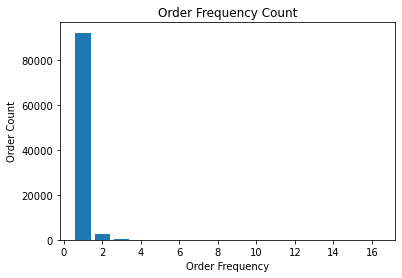

In [6]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_sk', 'count_order']] \
        .groupby('count_order', as_index=False).count()
ax.bar(t1['count_order'], t1['user_sk'])
ax.set_title('Order Frequency Count')
ax.set_xlabel('Order Frequency')
ax.set_ylabel('Order Count')

display(t1)
plt.show()

### Order Recency

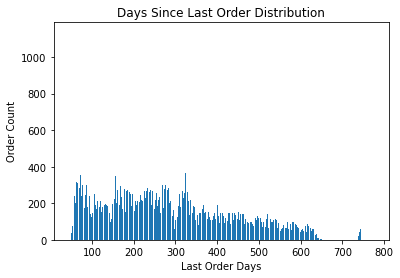

,days_since_last_order,count_order
0,45.0,1
1,50.0,11
2,51.0,39
3,52.0,66
4,53.0,73
5,54.0,69
6,55.0,96
7,56.0,142
8,57.0,184
9,58.0,239


In [7]:
fig, ax = plt.subplots()
t1 = customer_rfm.loc[:, ['user_sk', 'last_order_days']] \
        .groupby('last_order_days', as_index=False).count()
ax.bar(t1['last_order_days'], t1['user_sk'])
ax.set_title('Days Since Last Order Distribution')
ax.set_xlabel('Last Order Days')
ax.set_ylabel('Order Count')

plt.show()
t1.columns = ['days_since_last_order', 'count_order']
display(t1.head(15))

### Monetary Value

In [8]:
customer_rfm

,user_sk,total_spending,total_shipping_cost,count_order,last_order_days
0,4,75900.0,15280.0,1.0,470.0
1,6,29990.0,16110.0,1.0,429.0
2,7,19990.0,7390.0,1.0,177.0
3,8,14990.0,7780.0,1.0,279.0
4,11,1200000.0,37810.0,1.0,415.0
...,...,...,...,...,...
96092,96091,29000.0,15100.0,1.0,276.0
96093,96092,299900.0,14400.0,1.0,62.0
96094,96093,208000.0,39510.0,1.0,156.0
96095,96095,969990.0,51250.0,1.0,472.0


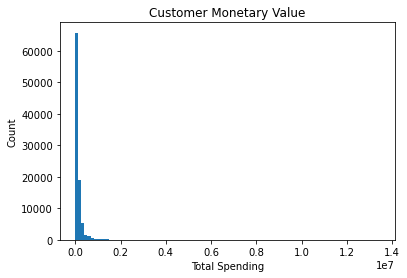

In [9]:
fig, ax = plt.subplots()

ax.hist(customer_rfm['total_spending'], bins=100)
ax.set_title('Customer Monetary Value')
ax.set_xlabel('Total Spending')
ax.set_ylabel('Count')

plt.show()

,monetary_value,user_sk
0,0.0,966
1,1.0,934
2,2.0,1048
3,3.0,865
4,4.0,948
...,...,...
93,93.0,951
94,94.0,940
95,95.0,953
96,96.0,947


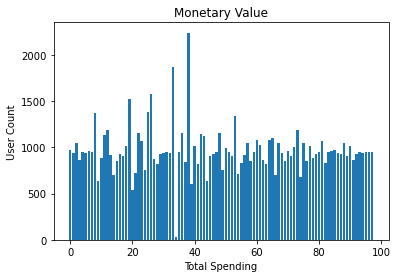

In [10]:
fig, ax = plt.subplots()

t0 = customer_rfm.copy()

t0['monetary_value'] = pd.qcut(customer_rfm['total_spending'], q=100, labels=False, duplicates='drop')
t1 = t0.loc[:, ['user_sk', 'monetary_value']] \
        .groupby('monetary_value', as_index=False).count()
ax.bar(t1['monetary_value'], t1['user_sk'])
ax.set_title('Monetary Value')
ax.set_xlabel('Total Spending')
ax.set_ylabel('User Count')

display(t1)
plt.show()

Manually assigned RFM score based on percentile.
<table>
    <tr>
        <th>Recency</th>
        <th>Frequency</th>
        <th>Monetary</th>
    </tr>
    <tr>
        <td>R-Tier-1 (most recent)</td>
        <td>F-Tier-1 (most frequent)</td>
        <td>M-Tier-1 (highest spend)</td>
    </tr>
    <tr>
        <td>R-Tier-2</td>
        <td>F-Tier-2</td>
        <td>M-Tier-2</td>
    </tr>
    <tr>
        <td>R-Tier-3</td>
        <td>F-Tier-3</td>
        <td>M-Tier-3</td>
    </tr>
    <tr>
        <td>R-Tier-4 (least recent)</td>
        <td>F-Tier-4 (least frequent)</td>
        <td>M-Tier-4 (lowest spend)</td>
    </tr>
</table>
Reiterating the goals again, the strategy prefer customer which has lower frequency but relatively higher monetary value. Below are the segment name assignment based on customer RFM score:<br>
<table>
<thead>
  <tr>
    <th>R</th>
    <th>F</th>
    <th>M</th>
    <th>Customer Segment</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1-2</td>
    <td>1-4</td>
    <td>1-2</td>
    <td>High-spending Active Customer **</td>
  </tr>
  <tr>
    <td>1-2</td>
    <td>1-4</td>
    <td>3-4</td>
    <td>Low-spending Active Customer *</td>
  </tr>
  <tr>
    <td>3-4</td>
    <td>1-4</td>
    <td>1-2</td>
    <td>Churned High-spending Customer **</td>
  </tr>
  <tr>
    <td>3-4</td>
    <td>1-4</td>
    <td>3-4</td>
    <td>Churned Low-spending Customer *</td>
  </tr>
</tbody>
</table>
<b>Note:</b><br>
** The best candidate to receive free shipping voucher is marked with double asterisk<br>
* The second best candidate is marked with single asterisk

## Data Preprocessing

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [12]:
df = customer_rfm.copy()
df = df.loc[:, ['last_order_days', 'count_order', 'total_spending']]
df = df.dropna()

In [13]:
minmax = MinMaxScaler()
df = pd.DataFrame(minmax.fit_transform(df))
df.columns = ['last_order_days', 'count_order', 'total_spending']

In [14]:
display(df.head(10))

,last_order_days,count_order,total_spending
0,0.582990,0.0,0.005584
1,0.526749,0.0,0.002168
2,0.181070,0.0,0.001424
3,0.320988,0.0,0.001052
4,0.507545,0.0,0.089228
5,0.379973,0.0,0.008858
6,0.319616,0.0,0.015563
7,0.791495,0.0,0.008121
8,0.278464,0.0,0.003955
9,0.220850,0.0,0.008494


## K-Means

### Using Elbow Method to Get Optimum n-cluster

In [15]:
from sklearn.cluster import KMeans

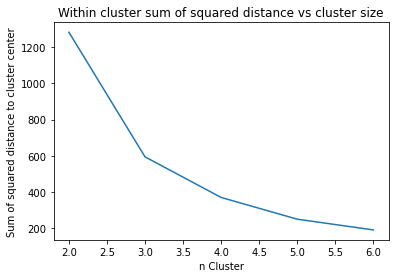

In [16]:
df1 = df.copy()

n_cluster = []
inertia_values = []

for i in range(2,7):
    kmeans = KMeans(n_clusters=i, random_state=111)
    y = kmeans.fit_predict(df1)
    n_cluster.append(i)
    inertia_values.append(kmeans.inertia_)

fig, ax = plt.subplots()

ax.plot(n_cluster, inertia_values)
ax.set_title('Within cluster sum of squared distance vs cluster size')
ax.set_xlabel('n Cluster')
ax.set_ylabel('Sum of squared distance to cluster center')

plt.show()

### Tuning

In [17]:
from sklearn.metrics import make_scorer

In [18]:
kmeans = KMeans()

pipe = Pipeline([
        ('kmeans', KMeans())])

sc_scorer = make_scorer(silhouette_score)

param_grid = dict(kmeans__n_clusters=[3,4,5,6,7,8,9],
                  kmeans__init=['k-means++', 'random'],
                  kmeans__tol=[0.0001,0.001,0.005,0.01,0.03,0.05,0.1,0.3,0.5])

gridsearch = GridSearchCV(pipe, param_grid, verbose=1)

gridsearch.fit(df1)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


GridSearchCV(estimator=Pipeline(steps=[('kmeans', KMeans())]),
             param_grid={'kmeans__init': ['k-means++', 'random'],
                         'kmeans__n_clusters': [3, 4, 5, 6, 7, 8, 9],
                         'kmeans__tol': [0.0001, 0.001, 0.005, 0.01, 0.03, 0.05,
                                         0.1, 0.3, 0.5]},
             verbose=1)

### Training Model

In [19]:
y = gridsearch.predict(df1)

### K-Means Evaluation

In [20]:
sc = silhouette_score(df1, y)
sc

0.48916252512123015

In [21]:
# kmeans.inertia_

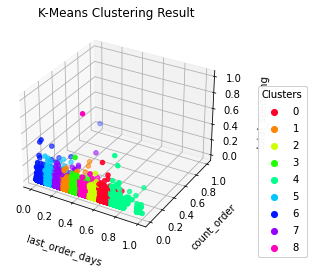

In [22]:
kmeans_df = df.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = kmeans_df.loc[:, 'last_order_days']
ys = kmeans_df.loc[:, 'count_order']
zs = kmeans_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs, ys, zs, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Means Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.3)
ax.set_ylabel('\ncount_order', linespacing=2.3)
ax.set_zlabel('\ntotal_spending', linespacing=2.3)

plt.show()

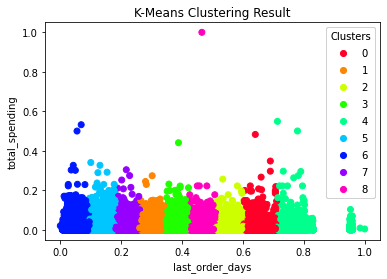

In [23]:
fig, ax = plt.subplots()

xs2 = kmeans_df.loc[:, 'last_order_days']
ys2 = kmeans_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs2, ys2, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Means Clustering Result')
ax.set_xlabel('last_order_days')
ax.set_ylabel('total_spending')

plt.show()

In [24]:
cluster_result = df.copy()
cluster_result.loc[:, 'cluster'] = y
cluster_result.loc[:, 'id'] = cluster_result.index

In [25]:
cluster_result.loc[:, ['id', 'cluster']] \
                .groupby('cluster', as_index=False).count()

,cluster,id
0,0,7636
1,1,12710
2,2,8064
3,3,12727
4,4,5258
5,5,13147
6,6,13726
7,7,13047
8,8,8668


## K-Medoids

### Remove Similar Feature Values

In [28]:
from sklearn_extra.cluster import KMedoids

In [29]:
_df = df.copy()

In [30]:
def encode(row):
    return "{:.3f}{:.3f}{:.3f}".format(
            row['last_order_days'],
            row['count_order'],
            row['total_spending'])

In [31]:
_df['_val'] = _df.apply(lambda row: encode(row), axis=1)

In [32]:
_df1 = _df.drop_duplicates(subset=['_val'])
_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20250 entries, 0 to 94981
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   last_order_days  20250 non-null  float64
 1   count_order      20250 non-null  float64
 2   total_spending   20250 non-null  float64
 3   _val             20250 non-null  object 
dtypes: float64(3), object(1)
memory usage: 791.0+ KB


In [33]:
_df1 = _df1.loc[:, ['last_order_days', 'count_order', 'total_spending']]

In [34]:
# n_cluster = []
# inertia_values = []

# for i in range(3,8):
#     kmedoids = KMedoids(n_clusters=i, random_state=111)
#     y = kmedoids.fit_predict(_df1)
#     n_cluster.append(i)
#     inertia_values.append(kmedoids.inertia_)

# fig, ax = plt.subplots()

# ax.plot(n_cluster, inertia_values)
# ax.set_title('Within cluster sum of squared distance vs cluster size')
# ax.set_xlabel('n Cluster')
# ax.set_ylabel('Sum of squared distance to cluster center')

# plt.show()

### Training Model

In [ ]:
# kmedoids = KMedoids(n_clusters=6, metric='euclidean', init='k-medoids++', method='alternate')
y = gridsearch.fit_predict(_df1)

### K-Medoids Evaluation

In [ ]:
sc = silhouette_score(_df1, y, metric='euclidean')
sc

In [ ]:
# kmedoids.inertia_

In [ ]:
kmedoids_df = _df1.copy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = kmedoids_df.loc[:, 'last_order_days']
ys = kmedoids_df.loc[:, 'count_order']
zs = kmedoids_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs, ys, zs, c=y, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Medoids Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.3)
ax.set_ylabel('\ncount_order', linespacing=2.3)
ax.set_zlabel('\ntotal_spending', linespacing=2.3)

plt.show()

In [ ]:
fig, ax = plt.subplots()

xs2 = kmedoids_df.loc[:, 'last_order_days']
ys2 = kmedoids_df.loc[:, 'total_spending']
axscatter = ax.scatter(xs2, ys2, c=y, alpha=0.1, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Medoids Clustering Result')
ax.set_xlabel('last_order_days')
ax.set_ylabel('total_spending')

plt.show()

In [ ]:
fig, ax = plt.subplots()

xs2 = kmedoids_df.loc[:, 'last_order_days']
ys2 = kmedoids_df.loc[:, 'count_order']
axscatter = ax.scatter(xs2, ys2, c=y, alpha=0.1, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('K-Medoids Clustering Result')
ax.set_xlabel('last_order_days')
ax.set_ylabel('count_order')

plt.show()

In [ ]:
def summarize_cluster_result(original_df, clusters):
    before_dedup = original_df.copy()
    after_dedup = before_dedup.drop_duplicates(subset=['_val']).copy()
    after_dedup.loc[:, 'cluster'] = clusters
    
    before_dedup_clusters = []

    for _, row in before_dedup.iterrows():
        _v = "{:.3f}{:.3f}{:.3f}".format(
                row['last_order_days'],
                row['count_order'],
                row['total_spending'])
        cluster = after_dedup[after_dedup["_val"] == _v].copy()
        cluster = cluster.iloc[0, 4]
        before_dedup_clusters.append(cluster)

    final_df = df.copy()
    final_df.loc[:, 'cluster'] = before_dedup_clusters
    final_df.loc[:, 'id'] = final_df.index
    
    summarize_clusters = final_df.loc[:, ['id', 'cluster']].copy()
    summarize_clusters = summarize_clusters.groupby('cluster', as_index=False).count()
    return summarize_clusters

In [ ]:
cluster_result = summarize_cluster_result(_df, y)
cluster_result

## Hierarchical Clustering

### Remove Similar Feature Values custom for HC

In [89]:
_df = df.copy()

In [90]:
def encode(row):
    return "{:.3f}{:.3f}{:.3f}".format(
            row['last_order_days'],
            row['count_order'],
            row['total_spending'])

In [91]:
_df['_val'] = _df.apply(lambda row: encode(row), axis=1)

In [92]:
_df1 = _df.drop_duplicates(subset=['_val'])

In [93]:
_df1 = _df1.loc[:, ['last_order_days', 'count_order', 'total_spending']]
_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20250 entries, 0 to 94981
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   last_order_days  20250 non-null  float64
 1   count_order      20250 non-null  float64
 2   total_spending   20250 non-null  float64
dtypes: float64(3)
memory usage: 632.8 KB


In [94]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [95]:
_df2 = _df1.copy()
_df2 = _df1.loc[:, ['last_order_days', 'count_order', 'total_spending']]
X = _df2.to_numpy()

In [96]:
X.shape

(20250, 3)

### Training Model

In [97]:
Z = linkage(X, method='median', metric='euclidean')

In [98]:
c, coph_dists = cophenet(Z, pdist(X, metric='euclidean'))
c

0.6690720309498501

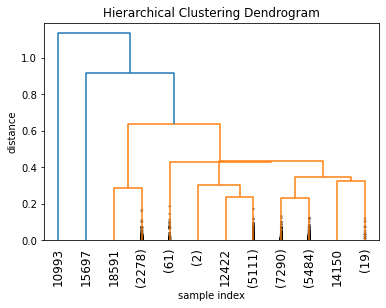

In [99]:
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()

In [100]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

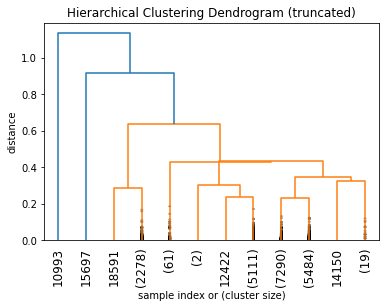

In [101]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

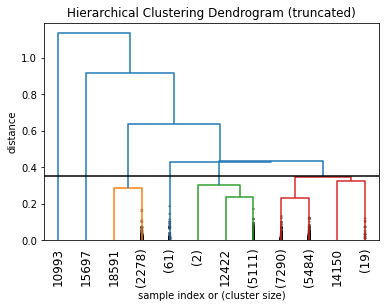

In [102]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.35,  # plot a horizontal cut-off line
)
plt.show()

In [103]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.35
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 4, 4, ..., 4, 3, 4], dtype=int32)

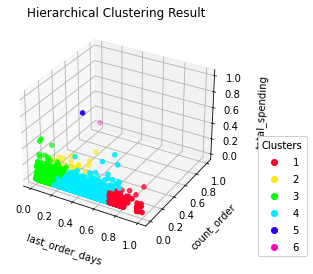

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

axscatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.0)
ax.set_ylabel('\ncount_order', linespacing=2.0)
ax.set_zlabel('\ntotal_spending', linespacing=2.0)

plt.show()

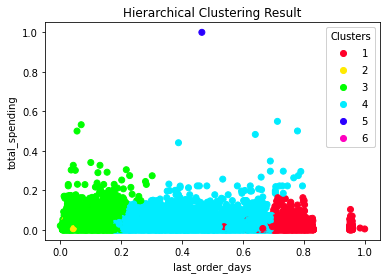

In [108]:
fig, ax = plt.subplots()

axscatter = ax.scatter(X[:,0], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('last_order_days')
ax.set_ylabel('total_spending')

plt.show()

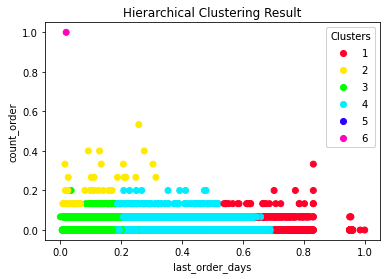

In [106]:
fig, ax = plt.subplots()

axscatter = ax.scatter(X[:,0], X[:,1], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('last_order_days')
ax.set_ylabel('count_order')

plt.show()

### Evaluation

In [79]:
sc = silhouette_score(X, clusters, metric='euclidean')
sc

0.31170166663590493

In [80]:
def summarize_cluster_result(original_df, clusters):
    before_dedup = original_df.copy()
    after_dedup = before_dedup.drop_duplicates(subset=['_val']).copy()
    after_dedup.loc[:, 'cluster'] = clusters
    
    before_dedup_clusters = []

    for _, row in before_dedup.iterrows():
        _v = "{:.3f}{:.3f}{:.3f}".format(
                row['last_order_days'],
                row['count_order'],
                row['total_spending'])
        cluster = after_dedup[after_dedup["_val"] == _v].copy()
        cluster = cluster.iloc[0, 4]
        before_dedup_clusters.append(cluster)

    final_df = df.copy()
    final_df.loc[:, 'cluster'] = before_dedup_clusters
    final_df.loc[:, 'id'] = final_df.index
    
    summarize_clusters = final_df.loc[:, ['id', 'cluster']].copy()
    summarize_clusters = summarize_clusters.groupby('cluster', as_index=False).count()
    return summarize_clusters

In [81]:
cluster_result = summarize_cluster_result(_df, clusters)
cluster_result

,cluster,id
0,1,6085
1,2,61
2,3,25943
3,4,62892
4,5,1
5,6,1


### With max_d of 0.05

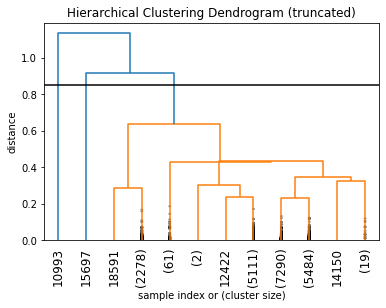

In [82]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=0.85,  # plot a horizontal cut-off line
)
plt.show()

In [83]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.85
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

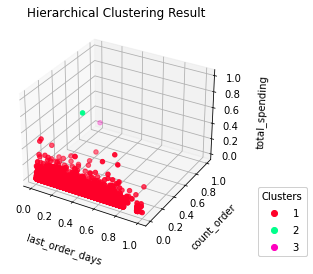

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

axscatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(),
                    bbox_to_anchor=(1.4, -0.1),
                    loc='lower right', title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('\nlast_order_days', linespacing=2.0)
ax.set_ylabel('\ncount_order', linespacing=2.0)
ax.set_zlabel('\ntotal_spending', linespacing=2.0)

plt.show()

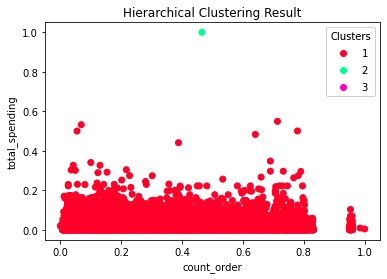

In [85]:
fig, ax = plt.subplots()

axscatter = ax.scatter(X[:,0], X[:,2], c=clusters, cmap='gist_rainbow')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*axscatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

ax.set_title('Hierarchical Clustering Result')
ax.set_xlabel('count_order')
ax.set_ylabel('total_spending')

plt.show()

In [86]:
def summarize_cluster_result(original_df, clusters):
    before_dedup = original_df.copy()
    after_dedup = before_dedup.drop_duplicates(subset=['_val']).copy()
    after_dedup.loc[:, 'cluster'] = clusters
    
    before_dedup_clusters = []

    for _, row in before_dedup.iterrows():
        _v = "{:.3f}{:.3f}{:.3f}".format(
                row['last_order_days'],
                row['count_order'],
                row['total_spending'])
        cluster = after_dedup[after_dedup["_val"] == _v].copy()
        cluster = cluster.iloc[0, 4]
        before_dedup_clusters.append(cluster)

    final_df = df.copy()
    final_df.loc[:, 'cluster'] = before_dedup_clusters
    final_df.loc[:, 'id'] = final_df.index
    
    summarize_clusters = final_df.loc[:, ['id', 'cluster']].copy()
    summarize_clusters = summarize_clusters.groupby('cluster', as_index=False).count()
    return summarize_clusters

In [87]:
cluster_result = summarize_cluster_result(_df, clusters)
cluster_result

,cluster,id
0,1,94981
1,2,1
2,3,1


#### Evaluation

In [88]:
sc = silhouette_score(X, clusters, metric='euclidean')
sc

0.7255391537125936